In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim  
from util.model_evaluation import ModelEvaluator
from util.plot import plot_predictions, plot_valid_test_only_predictions
import random
from statsmodels.tsa.arima.model import ARIMA
import os
import json
from collections import deque

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


In [2]:
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
random.seed(229)
torch.cuda.empty_cache()


In [3]:
#### Load High-Frequency Data ####

data_path = "../data/btc_usdt_1m_2017_8_to_2023_12.csv"
data = pd.read_csv(data_path, dtype=str)

print("Column names:", data.columns)
features = ['high', 'low', 'open', 'close', 'volume']

df = data

# Convert 'timestamp' to datetime and round any fractional seconds
print("Original Timestamps (First 5):", data['timestamp'].head())
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce') // 1000
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
print("Converted Timestamps (First 5):", df['timestamp'].head())
df['timestamp'] = df['timestamp'].dt.round('1s')
df = df.drop_duplicates(subset=['timestamp'], keep='first').reset_index(drop=True)

# Ensure key data columns are numeric
for col in features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Create Dollar-Weighted Volume
df["dollar_volume"] = df["volume"]*df["close"]
#aggregated["dollar_volume"] = aggregated["volume"]*average_prices
periods_per_30_days = 1*60*24*30
df['30_day_dollar_ADTV'] = df['dollar_volume'].rolling(window=periods_per_30_days, min_periods=1).mean() 
df['normalized_dollar_volume'] = df['dollar_volume'] / df['30_day_dollar_ADTV']

# Create a column for the 30-minute groupings based on the timestamp floor
df['time_group'] = df['timestamp'].dt.floor('60min')
#periods_per_day = 24*2

# Perform the aggregation within each 30-minute group
aggregated = df.groupby('time_group').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'normalized_dollar_volume': 'mean'
}).reset_index()

print(aggregated)

# Calculate percentage returns for each column in `features`
for col in features:
    aggregated[f'{col}_return'] = aggregated[col].pct_change()

# Drop rows with NaN values resulting from percentage change calculation
aggregated = aggregated.dropna().reset_index(drop=True)

# Clip the returns at ±10% for each feature
for col in features:
    aggregated[f'{col}_return'] = aggregated[f'{col}_return'].clip(lower=-0.1, upper=0.1)

# Select only the return columns in the order of `features`
return_features = [f'{col}_return' for col in features]
features = ['high_return', 'low_return', 'open_return', 'close_return']
aggregated_returns = aggregated[return_features]

# print("Aggregated Data with Returns:")
# print(aggregated)

# Optional: View the final returns-only DataFrame if you need it
# print("Aggregated Returns-Only DataFrame:")
# print(aggregated_returns)

# Delete the original 1-minute data DataFrame to free up memory
del data, df

# Assign the final processed close column for potential further use
btc_close = aggregated['close']
btc_close_pct = aggregated['close_return']

Column names: Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume',
       'taker_buy_quote_volume'],
      dtype='object')
Original Timestamps (First 5): 0    1502942400000
1    1502942460000
2    1502942520000
3    1502942580000
4    1502942640000
Name: timestamp, dtype: object
Converted Timestamps (First 5): 0   2017-08-17 04:00:00+00:00
1   2017-08-17 04:01:00+00:00
2   2017-08-17 04:02:00+00:00
3   2017-08-17 04:03:00+00:00
4   2017-08-17 04:04:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
                     time_group      open      high       low     close  \
0     2017-08-17 04:00:00+00:00   4261.48   4313.62   4261.32   4308.83   
1     2017-08-17 05:00:00+00:00   4308.83   4328.69   4291.37   4315.32   
2     2017-08-17 06:00:00+00:00   4315.32   4345.45   4309.37   4324.35   
3     2017-08-17 07:00:00+00:00   4324.35   4349.99   4287.41   4349.99   
4     2017-08-17 08:00

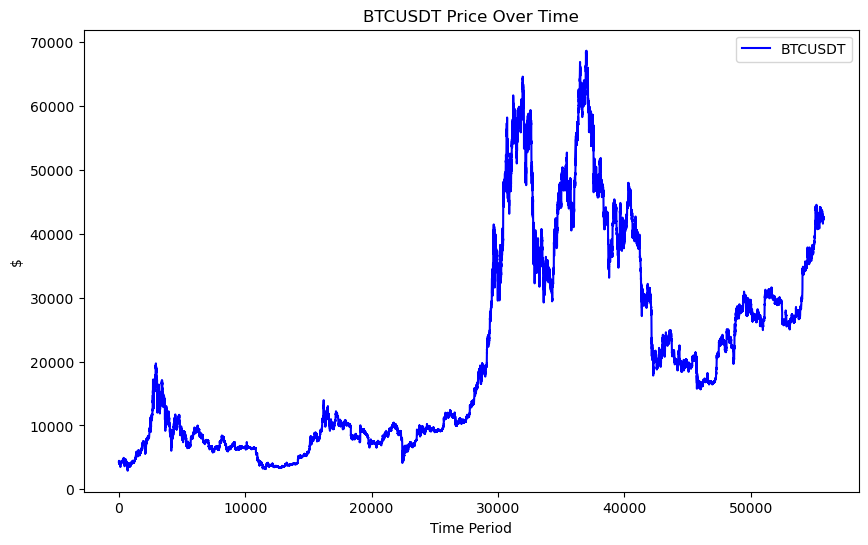

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(btc_close, label="BTCUSDT", color="blue")
plt.xlabel("Time Period")
plt.ylabel("$")
plt.title("BTCUSDT Price Over Time")
plt.legend()
plt.grid(False)
plt.show()

In [5]:
# Step 3: Update the sequence creation function to use unscaled percentage changes and scaled volumes
def create_windowed_sequences(data, window_size, forecast_horizon=5):
    sequences = []
    targets = []
    data_array = data[['open_return', 'high_return', 'low_return', 'close_return','normalized_dollar_volume']].values
    for i in range(len(data_array) - window_size - forecast_horizon + 1):
        sequence = data_array[i:i+window_size]
        target = data_array[i + window_size:i + window_size + forecast_horizon]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def create_windowed_sequences_levels(data, window_size, forecast_horizon=5):
    sequences = []
    targets = []
    data_array = data[['open', 'high', 'low', 'close','normalized_dollar_volume']].values
    for i in range(len(data_array) - window_size - forecast_horizon + 1):
        sequence = data_array[i:i+window_size]
        target = data_array[i + window_size:i + window_size + forecast_horizon]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [6]:
def window_series_multivariate(series_df, input_window=100, forecast_window=30, n_windows0=10000):
    n_periods = series_df.shape[0]
    n_features = series_df.shape[1]
    window_length = input_window + forecast_window
    n_windows = min(n_periods - window_length + 1, n_windows0)
    
    # Initialize the window array for multivariate series
    window_array = np.zeros((window_length, n_windows, n_features))
    
    for w in range(n_windows):
        window = series_df.iloc[w:(w + window_length)].values
        window_array[:, w, :] = window

    # Separate into input and forecast data
    input_data = window_array[0:input_window, :, :]
    forecast_data = window_array[input_window:, :, :]
    
    return input_data, forecast_data

In [7]:
# Set parameters
window_size = 1*24*20 # per-hour*hours-per-day*days
forecast_horizon = 1*24*1 # 1 day

variables = ['open_return', 'high_return', 'low_return', 'close_return','normalized_dollar_volume']
variables_levels = ['open', 'high', 'low', 'close','normalized_dollar_volume']
df_model = aggregated[variables]
df_model_levels = aggregated[variables_levels]
print("Getting X, y")
X, y = create_windowed_sequences(df_model, window_size, forecast_horizon = forecast_horizon)
print("Getting X_prices, y_prices")
X_prices, y_prices = create_windowed_sequences_levels(df_model_levels, window_size, forecast_horizon = forecast_horizon)

#X_pm, y_pm = window_series_multivariate(df_model, window_size, forecast_window = forecast_horizon, n_windows0 = 160000)


Getting X, y
Getting X_prices, y_prices


In [8]:
print(df_model.shape)
print(X.shape)
print(y.shape)
#print(X_pm.shape)
#print(y_pm.shape)
print(X_prices.shape)
print(y_prices.shape)

(55740, 5)
(55237, 480, 5)
(55237, 24, 5)
(55237, 480, 5)
(55237, 24, 5)


In [9]:
def run_arima_windows_univariate(data_train, data_forecast_actuals, p=0, d=0, q=0, trend=None, horizon=30):
    """
    Function to run ARIMA model on a univariate time series data window.
    If p = d = q = 0, forecasts are based on a random walk without drift.

    Parameters:
    - data_train: 2D numpy array, shape (input_window, n_windows) for the training data windows.
    - data_forecast_actuals: 2D numpy array, shape (forecast_window, n_windows) for the actual future data.
    - p, d, q: ARIMA model order parameters.
    - trend: Trend parameter for ARIMA model. For a random walk with drift, use 'c' (constant).
    - horizon: Forecast horizon, i.e., number of steps to forecast.

    Returns:
    - forecast_matrix: 2D numpy array with forecasts, shape (horizon, n_windows).
    - model_accuracy_table: DataFrame with accuracy metrics for each horizon step.
    """
    n_windows = data_train.shape[0]
    
    # Initialize forecast and error matrices
    forecast_matrix = np.full((horizon, n_windows), np.nan)
    error_matrix = np.full((horizon, n_windows), np.nan)
    
    if p == 0 and d == 0 and q == 0 and trend == None:
        # If p=d=q=0, we have a random walk (no drift).
        # Simply predict the last value in each training window for all forecast steps.
        forecast_matrix[:] = 0  # Set all forecast steps to 0 growth in RW no Drift
    else:
        # Run ARIMA model for each window
        for w in range(n_windows):
            model = ARIMA(data_train[w, :], order=(p, d, q), trend=trend)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=horizon)
            forecast_matrix[:, w] = forecast
            if w % 20 == 0:
                print(f"Window: {w} / {n_windows}")

    # Compute errors
    data_forecast_actuals_transpose = data_forecast_actuals.T
    error_matrix = forecast_matrix - data_forecast_actuals_transpose
    


    # Calculate accuracy metrics
    accuracy_matrix = np.zeros((6, horizon))

    for h in range(horizon):
        # Errors at step h
        horizon_errors = error_matrix[h, :]
        actuals_at_horizon = data_forecast_actuals_transpose[h, :]
        
        # Compute accuracy metrics for the unnormalized errors
        accuracy_matrix[0, h] = np.sqrt(np.mean(horizon_errors**2))  # RMSE
        accuracy_matrix[1, h] = np.mean(horizon_errors**2)  # MSE
        accuracy_matrix[2, h] = np.mean(horizon_errors)  # ME
        accuracy_matrix[3, h] = np.mean(np.abs(horizon_errors / (actuals_at_horizon + 1e-8)))  # MAPE
        accuracy_matrix[4, h] = np.mean(horizon_errors / (actuals_at_horizon + 1e-8))  # MPE

        ss_res = np.sum(horizon_errors**2)  # Residual sum of squares
        ss_tot = np.sum((actuals_at_horizon - np.mean(actuals_at_horizon))**2)  # Total sum of squares
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0  # Handle edge case where ss_tot = 0
        accuracy_matrix[5, h] = r_squared

    # Create DataFrame for accuracy table
    model_accuracy_table = pd.DataFrame(
        accuracy_matrix.T, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
    )

    return forecast_matrix, model_accuracy_table

In [10]:
# Calculate exact split sizes
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15
total_size = len(X)

In [11]:
# First, calculate training and validation sizes
train_size = int(total_size * train_ratio)
valid_size = int(total_size * valid_ratio)
test_size = total_size - (train_size + valid_size)  # Assign remaining data to test to ensure total matches


In [12]:
# Apply the split
X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size + valid_size], y[train_size:train_size + valid_size]
X_test, y_test = X[train_size + valid_size:], y[train_size + valid_size:]

X_train_prices, y_train_prices = X_prices[:train_size], y_prices[:train_size]
X_valid_prices, y_valid_prices = X_prices[train_size:train_size + valid_size], y_prices[train_size:train_size + valid_size]
X_test_prices, y_test_prices = X_prices[train_size + valid_size:], y_prices[train_size + valid_size:]


In [13]:
combined_length = len(X_train) + len(X_valid) + len(X_test)
print(combined_length)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(X_test[:,:,3].shape)
print(y_test[:,:,3].shape)

55237
(38665, 480, 5)
(8285, 480, 5)
(8287, 480, 5)
(8287, 480)
(8287, 24)


In [14]:
forecast_matrix_RW_test, model_accuracy_table_RW_test = run_arima_windows_univariate(X_test[:,:,3],
                                                                              y_test[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)
forecast_matrix_RW_valid, model_accuracy_table_RW_valid = run_arima_windows_univariate(X_valid[:,:,3],
                                                                              y_valid[:,:,3],
                                                                              p=0, d=0, q=0,
                                                                              trend = None,
                                                                              horizon=forecast_horizon)

In [15]:
print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)

model_accuracy_table_RW_test.to_csv('model_accuracy_table_RW_test.csv', index=False)
np.save('forecast_matrix_RW_test.npy', forecast_matrix_RW_test)

model_accuracy_table_RW_test = pd.read_csv('model_accuracy_table_RW_test.csv', na_values=["inf", "NaN"])
forecast_matrix_RW_test = np.load('forecast_matrix_RW_test.npy')
print(model_accuracy_table_RW_test)
print(forecast_matrix_RW_test)



        RMSE       MSE        ME      MAPE       MPE       R^2
0   0.004540  0.000021 -0.000096  0.999874 -0.999874 -0.000445
1   0.004540  0.000021 -0.000095  0.999874 -0.999874 -0.000441
2   0.004540  0.000021 -0.000094  0.999874 -0.999874 -0.000432
3   0.004539  0.000021 -0.000094  0.999874 -0.999874 -0.000428
4   0.004539  0.000021 -0.000094  0.999874 -0.999874 -0.000429
5   0.004538  0.000021 -0.000095  0.999874 -0.999874 -0.000437
6   0.004538  0.000021 -0.000094  0.999874 -0.999874 -0.000432
7   0.004538  0.000021 -0.000095  0.999874 -0.999874 -0.000439
8   0.004538  0.000021 -0.000095  0.999874 -0.999874 -0.000438
9   0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000442
10  0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000442
11  0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000438
12  0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000440
13  0.004539  0.000021 -0.000095  0.999874 -0.999874 -0.000442
14  0.004539  0.000021 -0.000096  0.999874 -0.999874 -0

In [16]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)



In [17]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        x = self.fc(lstm_out[:, -1, :])
        return x.view(-1, forecast_horizon, input_dim)

In [18]:
# Hyperparameters
input_dim = 5
hidden_dim = 200
num_layers = 1
output_dim = forecast_horizon * 5
num_epochs = 100
batch_size = 20 # 32
learning_rate = 0.0001 # 0.001
dropout_rate = 0.2
patience = 5


In [19]:
# Initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Prepare DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

In [20]:
# Perform Hyper Parameter Search Based on Validation Loss for Closing Price Validation Loss --- With GAMMA

# Make a Discounted SmoothL1Loss Function:
class DiscountedSmoothL1Loss(nn.Module):
    def __init__(self, gamma=0.9, beta=1.0):
        """
        Initializes the DiscountedSmoothL1Loss module.
        Args:
            gamma (float): Initial discount rate for the forecast horizon.
            beta (float): Transition point for SmoothL1Loss.
        """
        super(DiscountedSmoothL1Loss, self).__init__()
        self.gamma = gamma
        self.beta = beta

    def set_gamma(self, gamma):
        """
        Update the discount rate gamma dynamically.
        Args:
            gamma (float): New discount rate.
        """
        self.gamma = gamma

    def forward(self, predictions, targets):
        """
        Compute the discounted SmoothL1Loss.
        Args:
            predictions (torch.Tensor): Predicted values of shape (batch_size, horizon, *dims).
            targets (torch.Tensor): True values of shape (batch_size, horizon, *dims).
        Returns:
            torch.Tensor: Discounted SmoothL1 loss.
        """
        horizon = predictions.size(1)  # Assumes shape (batch_size, horizon, ...)
        
        # Compute absolute difference
        diff = torch.abs(predictions - targets)

        # Compute SmoothL1 loss for each forecast step
        loss = torch.where(
            diff < self.beta,
            0.5 * (diff**2) / self.beta,
            diff - 0.5 * self.beta
        )

        # Apply discount factors
        discount_factors = torch.tensor([self.gamma**(h-1) for h in range(1, horizon + 1)], device=loss.device)
        discount_factors = discount_factors.view(1, -1, *(1,) * (loss.ndim - 2))  # Broadcast to match dims
        weighted_loss = loss * discount_factors

        return weighted_loss.mean()  # Return mean loss

# Define best hyperparameters for Round 1 and Round 2
best_round_1 = {"hidden_dim": 20, "num_layers": 1, "batch_size": 128, "dropout_rate": 0.2, "gamma": 1}
best_round_2 = {"hidden_dim": 64, "num_layers": 1, "batch_size": 64, "dropout_rate": 0.2, "gamma": 1}

# Combine both rounds into a list for trials
hyperparameter_sets = [best_round_1] * 5 + [best_round_2] * 5  # 5 trials each

# Initialize model, loss function, and optimizer
discounted_criterion = DiscountedSmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

input_dim = 5
output_dim = forecast_horizon * 5
patience = 10  # Stopping condition
learning_rate = 0.0001
num_epochs = 100

# Initialize storage for results
train_losses_master = []
train_losses_close_master = []
val_losses_master = []
val_losses_close_master = []
best_model_state_master = []
best_model_state_close_master = []
hyperparameter_results = []

# Iterate over each hyperparameter set
for trial, params in enumerate(hyperparameter_sets, start=1):
    print(f"Trial {trial}/{len(hyperparameter_sets)} with params: {params}")
    hidden_dim = params["hidden_dim"]
    num_layers = params["num_layers"]
    batch_size = params["batch_size"]
    dropout_rate = params["dropout_rate"]
    gamma = params["gamma"]

    # Initialize model, loss function, and optimizer
    model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout_rate).to(device)
    training_criterion = DiscountedSmoothL1Loss()
    training_criterion.set_gamma(gamma)
    valid_criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare DataLoader
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    val_data = TensorDataset(X_valid, y_valid)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

    # Training loop with early stopping
    best_val_loss = float('inf')
    best_val_loss_close = float('inf')
    epochs_no_improve = 0

    train_losses = []
    train_losses_close = []
    val_losses = []
    val_losses_close = [] 

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        epoch_train_loss_close = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = training_criterion(outputs, targets)
            loss_close = valid_criterion(outputs[:,:,3], targets[:,:,3]) # Not a typo - I want comparable training loss and its only the gradient descent I want the discounted criterion
            epoch_train_loss += loss.item()
            epoch_train_loss_close += loss_close.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        avg_train_loss_close = epoch_train_loss_close / len(train_loader)
        train_losses_close.append(avg_train_loss_close)

        # Validation loss
        model.eval()
        epoch_val_loss = 0
        epoch_val_loss_close = 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs)
                val_loss = valid_criterion(val_outputs, val_targets)
                val_loss_close = valid_criterion(val_outputs[:,:,3], val_targets[:,:,3])
                epoch_val_loss += val_loss.item()
                epoch_val_loss_close += val_loss_close.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        avg_val_loss_close = epoch_val_loss_close / len(val_loader)
        val_losses_close.append(avg_val_loss_close)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {avg_train_loss:.10f}, "
          f"Validation Loss: {avg_val_loss:.10f}, "
          f"Validation Loss (Close): {avg_val_loss_close:.10f}")

        # Check early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if avg_val_loss_close < best_val_loss_close:
            best_val_loss_close = avg_val_loss_close
            epochs_no_improve_close = 0
            best_model_state_close = model.state_dict()
        else:
            epochs_no_improve_close += 1

        if epochs_no_improve_close >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs (Based on Closing Price Returns).")
            break

    # Save trial results
    train_losses_master.append(train_losses)
    train_losses_close_master.append(train_losses_close)
    val_losses_master.append(val_losses)
    val_losses_close_master.append(val_losses_close)
    best_model_state_master.append(best_model_state.copy())

    result = {
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "batch_size": batch_size,
        "dropout_rate": dropout_rate,
        "gamma": gamma,
        "best_val_loss": best_val_loss,
        "best_val_loss_close": best_val_loss_close,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_losses_close": train_losses_close,
        "val_losses_close": val_losses_close,
        "best_model_state": best_model_state,
        "best_model_state_close": best_model_state_close,
    }
    hyperparameter_results.append(result)

# Save results to analyze further
print("Trials completed.")


Trial 1/10 with params: {'hidden_dim': 20, 'num_layers': 1, 'batch_size': 128, 'dropout_rate': 0.2, 'gamma': 1}
Epoch [1/100], Training Loss: 0.1300326508, Validation Loss: 0.1029912106, Validation Loss (Close): 0.0055656360
Epoch [2/100], Training Loss: 0.0777188632, Validation Loss: 0.0482996118, Validation Loss (Close): 0.0002841944
Epoch [3/100], Training Loss: 0.0566282324, Validation Loss: 0.0427065392, Validation Loss (Close): 0.0005229108
Epoch [4/100], Training Loss: 0.0513154954, Validation Loss: 0.0415871996, Validation Loss (Close): 0.0004647854
Epoch [5/100], Training Loss: 0.0490716875, Validation Loss: 0.0411111806, Validation Loss (Close): 0.0003562368
Epoch [6/100], Training Loss: 0.0477419629, Validation Loss: 0.0407623528, Validation Loss (Close): 0.0002443364
Epoch [7/100], Training Loss: 0.0469200286, Validation Loss: 0.0406051074, Validation Loss (Close): 0.0001745916
Epoch [8/100], Training Loss: 0.0464467599, Validation Loss: 0.0405686875, Validation Loss (Close

Epoch [29/100], Training Loss: 0.0084664962, Validation Loss: 0.0406226250, Validation Loss (Close): 0.0000116410
Epoch [30/100], Training Loss: 0.0084404032, Validation Loss: 0.0405503722, Validation Loss (Close): 0.0000116617
Epoch [31/100], Training Loss: 0.0084174727, Validation Loss: 0.0406249413, Validation Loss (Close): 0.0000116837
Epoch [32/100], Training Loss: 0.0084126905, Validation Loss: 0.0405882861, Validation Loss (Close): 0.0000117098
Epoch [33/100], Training Loss: 0.0084195335, Validation Loss: 0.0405392092, Validation Loss (Close): 0.0000117027
Epoch [34/100], Training Loss: 0.0084077120, Validation Loss: 0.0406387586, Validation Loss (Close): 0.0000116756
Epoch [35/100], Training Loss: 0.0083864953, Validation Loss: 0.0405216352, Validation Loss (Close): 0.0000116855
Epoch [36/100], Training Loss: 0.0084090112, Validation Loss: 0.0404508016, Validation Loss (Close): 0.0000116868
Epoch [37/100], Training Loss: 0.0084001327, Validation Loss: 0.0407398766, Validation L

Epoch [63/100], Training Loss: 0.0044791186, Validation Loss: 0.0401897299, Validation Loss (Close): 0.0000121261
Epoch [64/100], Training Loss: 0.0044929383, Validation Loss: 0.0402336973, Validation Loss (Close): 0.0000121486
Epoch [65/100], Training Loss: 0.0044909532, Validation Loss: 0.0402274834, Validation Loss (Close): 0.0000121358
Epoch [66/100], Training Loss: 0.0044804832, Validation Loss: 0.0401448889, Validation Loss (Close): 0.0000120847
Epoch [67/100], Training Loss: 0.0044834207, Validation Loss: 0.0401999396, Validation Loss (Close): 0.0000120849
Epoch [68/100], Training Loss: 0.0044782657, Validation Loss: 0.0402198365, Validation Loss (Close): 0.0000120844
Epoch [69/100], Training Loss: 0.0044742386, Validation Loss: 0.0405033364, Validation Loss (Close): 0.0000120777
Epoch [70/100], Training Loss: 0.0044705636, Validation Loss: 0.0404127421, Validation Loss (Close): 0.0000120813
Epoch [71/100], Training Loss: 0.0044721808, Validation Loss: 0.0402086270, Validation L

Epoch [1/100], Training Loss: 0.0186755689, Validation Loss: 0.0453100341, Validation Loss (Close): 0.0002914669
Epoch [2/100], Training Loss: 0.0102957391, Validation Loss: 0.0415263385, Validation Loss (Close): 0.0001469553
Epoch [3/100], Training Loss: 0.0095198276, Validation Loss: 0.0411378172, Validation Loss (Close): 0.0000849882
Epoch [4/100], Training Loss: 0.0091674215, Validation Loss: 0.0410379030, Validation Loss (Close): 0.0000541990
Epoch [5/100], Training Loss: 0.0089437786, Validation Loss: 0.0408783587, Validation Loss (Close): 0.0000500501
Epoch [6/100], Training Loss: 0.0088099418, Validation Loss: 0.0408579902, Validation Loss (Close): 0.0000442812
Epoch [7/100], Training Loss: 0.0087138040, Validation Loss: 0.0408055791, Validation Loss (Close): 0.0000425330
Epoch [8/100], Training Loss: 0.0086324116, Validation Loss: 0.0408860783, Validation Loss (Close): 0.0000286694
Epoch [9/100], Training Loss: 0.0085846200, Validation Loss: 0.0408880539, Validation Loss (Clos

Epoch [39/100], Training Loss: 0.0044674397, Validation Loss: 0.0396626758, Validation Loss (Close): 0.0000139801
Epoch [40/100], Training Loss: 0.0044470350, Validation Loss: 0.0394098187, Validation Loss (Close): 0.0000146176
Epoch [41/100], Training Loss: 0.0044437562, Validation Loss: 0.0392927357, Validation Loss (Close): 0.0000147864
Epoch [42/100], Training Loss: 0.0044341869, Validation Loss: 0.0391792190, Validation Loss (Close): 0.0000153236
Epoch [43/100], Training Loss: 0.0044279163, Validation Loss: 0.0389119149, Validation Loss (Close): 0.0000152143
Epoch [44/100], Training Loss: 0.0044196615, Validation Loss: 0.0388461923, Validation Loss (Close): 0.0000147996
Early stopping triggered after 44 epochs (Based on Closing Price Returns).
Hyperparameter Alternative: [7/9], Hidden Dimensions: 50, Number of Layers: 2, Batch Size: 128, Dropout Rate: 0.3, Gamma: 1
Epoch [1/100], Training Loss: 0.0884727316, Validation Loss: 0.0421774807, Validation Loss (Close): 0.0002271604
Epoc

Epoch [32/100], Training Loss: 0.0080556833, Validation Loss: 0.0374877681, Validation Loss (Close): 0.0000117303
Epoch [33/100], Training Loss: 0.0080485560, Validation Loss: 0.0377267545, Validation Loss (Close): 0.0000117533
Epoch [34/100], Training Loss: 0.0080385460, Validation Loss: 0.0377923945, Validation Loss (Close): 0.0000117011
Epoch [35/100], Training Loss: 0.0080437611, Validation Loss: 0.0378365835, Validation Loss (Close): 0.0000117851
Epoch [36/100], Training Loss: 0.0080321507, Validation Loss: 0.0377746541, Validation Loss (Close): 0.0000117492
Epoch [37/100], Training Loss: 0.0080229542, Validation Loss: 0.0376197323, Validation Loss (Close): 0.0000117543
Epoch [38/100], Training Loss: 0.0079913629, Validation Loss: 0.0374571298, Validation Loss (Close): 0.0000117377
Early stopping triggered after 38 epochs (Based on Closing Price Returns).
Hyperparameter Alternative: [9/9], Hidden Dimensions: 50, Number of Layers: 2, Batch Size: 128, Dropout Rate: 0.3, Gamma: 0.65


Epoch [65/100], Training Loss: 0.0042820381, Validation Loss: 0.0374300227, Validation Loss (Close): 0.0000118364
Epoch [66/100], Training Loss: 0.0042883569, Validation Loss: 0.0376207457, Validation Loss (Close): 0.0000117641
Epoch [67/100], Training Loss: 0.0042791038, Validation Loss: 0.0376123743, Validation Loss (Close): 0.0000118131
Epoch [68/100], Training Loss: 0.0042808960, Validation Loss: 0.0375183281, Validation Loss (Close): 0.0000118246
Epoch [69/100], Training Loss: 0.0042700071, Validation Loss: 0.0373533612, Validation Loss (Close): 0.0000118120
Epoch [70/100], Training Loss: 0.0042688857, Validation Loss: 0.0372411087, Validation Loss (Close): 0.0000118168
Epoch [71/100], Training Loss: 0.0042734804, Validation Loss: 0.0374448653, Validation Loss (Close): 0.0000118162
Epoch [72/100], Training Loss: 0.0042761388, Validation Loss: 0.0373229660, Validation Loss (Close): 0.0000117747
Epoch [73/100], Training Loss: 0.0042782989, Validation Loss: 0.0377379647, Validation L

In [21]:
save_dir = "../results/"

# Save metadata
results_metadata = [
    {
        "hidden_dim": result["hidden_dim"],
        "num_layers": result["num_layers"],
        "batch_size": result["batch_size"],
        "dropout_rate": result["dropout_rate"],
        "gamma": result["gamma"],
        "best_val_loss": result["best_val_loss"],
        "best_val_loss_close": result["best_val_loss_close"]

    }
    for result in hyperparameter_results
]

metadata_path = os.path.join(save_dir, "results_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(results_metadata, f, indent=4)

In [22]:
# Save each model state
for i, result in enumerate(hyperparameter_results):
    model_path = os.path.join(save_dir, f"2024_11_26_best_model_state_BTCUSDT_{i}.pth")
    torch.save(result["best_model_state"], model_path)

print(f"Metadata saved to {metadata_path}. Model states saved to {save_dir}.")

#for i, result in enumerate(hyperparameter_results):
#    torch.save(result["best_model_state"], f"best_model_state_BTCUSDT_with_gamma_{i}.pth")
#print("Model states saved as best_model_state_BTCUSDT_with_gamma_0.pth, best_model_state_BTCUSDT_with_gamma_1.pth, ...")

Metadata saved to ../results/results_metadata.json. Model states saved to ../results/.


In [23]:
# Load Hyper Parameter Results
with open(metadata_path, "r") as f:
    loaded_metadata = json.load(f)

# Reload models
loaded_results = []
for i, meta in enumerate(loaded_metadata):
    model_path = os.path.join(save_dir, f"best_model_state_BTCUSDT_with_gamma_{i}.pth")
    model_state = torch.load(model_path, weights_only=True)

    result = {
        "hidden_dim": meta["hidden_dim"],
        "num_layers": meta["num_layers"],
        "batch_size": meta["batch_size"],
        "dropout_rate": meta["dropout_rate"],
        "best_val_loss": meta["best_val_loss"],
        "best_val_loss_close": meta["best_val_loss_close"],
        "gamma": meta["gamma"],
        "best_model_state": model_state
    }
    loaded_results.append(result)

print("Results reloaded successfully!")

Results reloaded successfully!


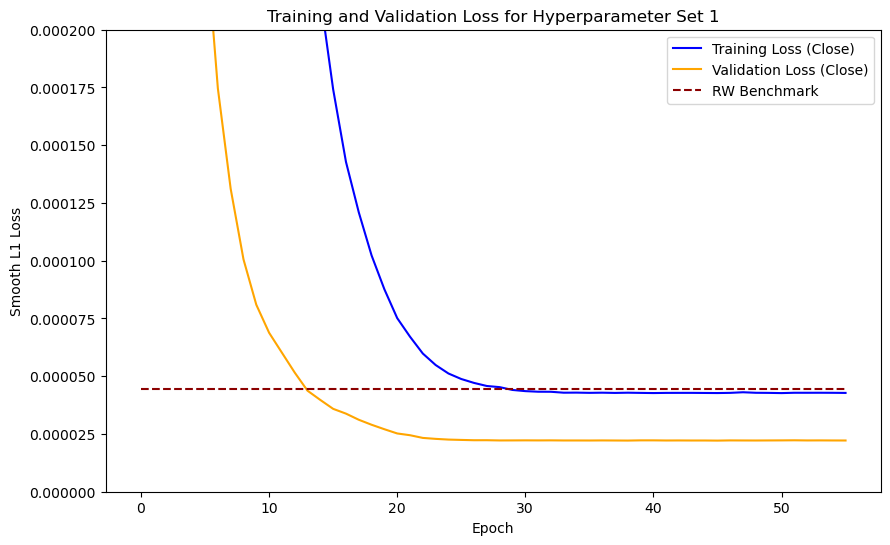

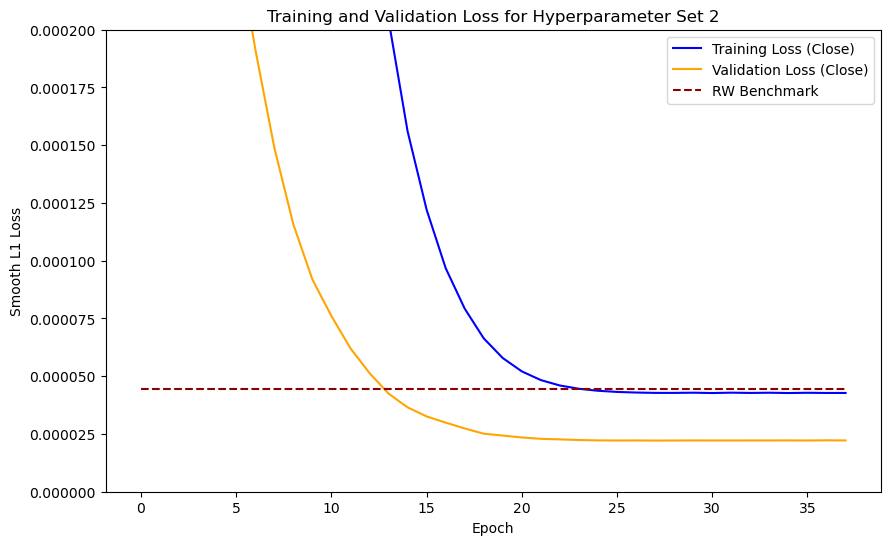

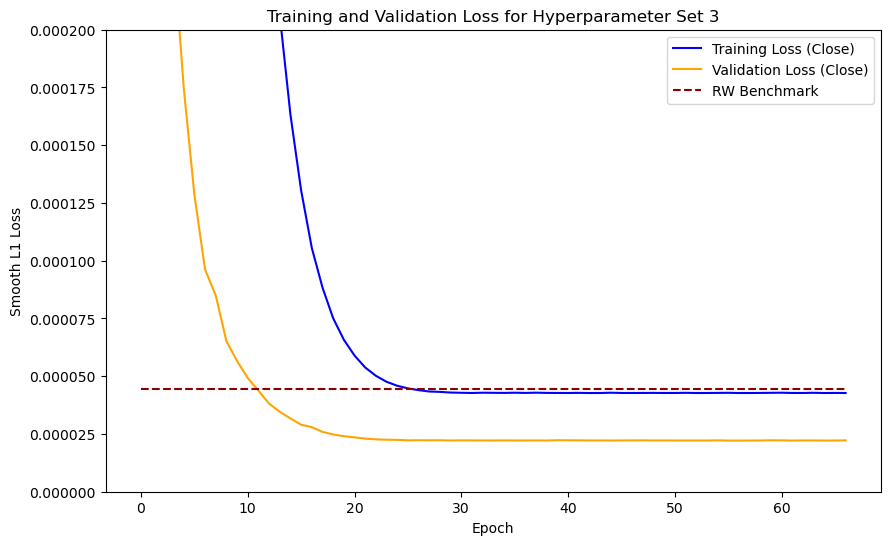

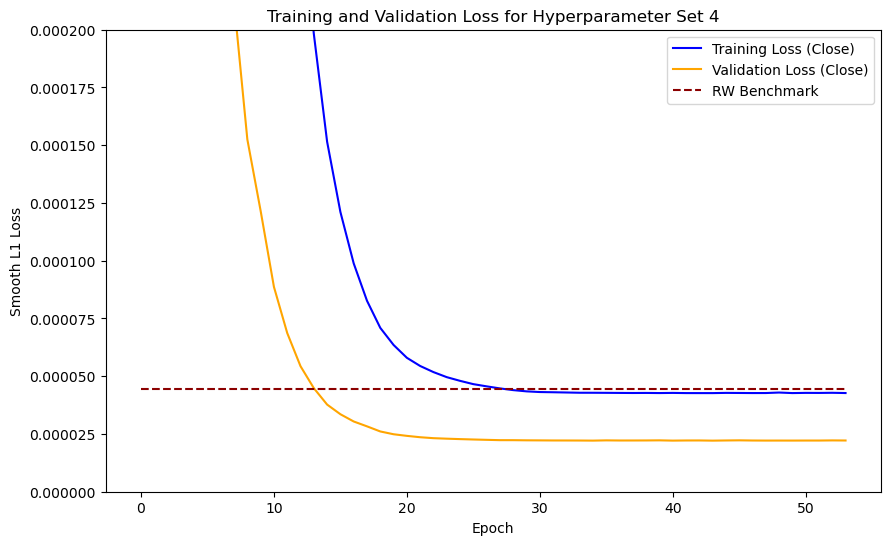

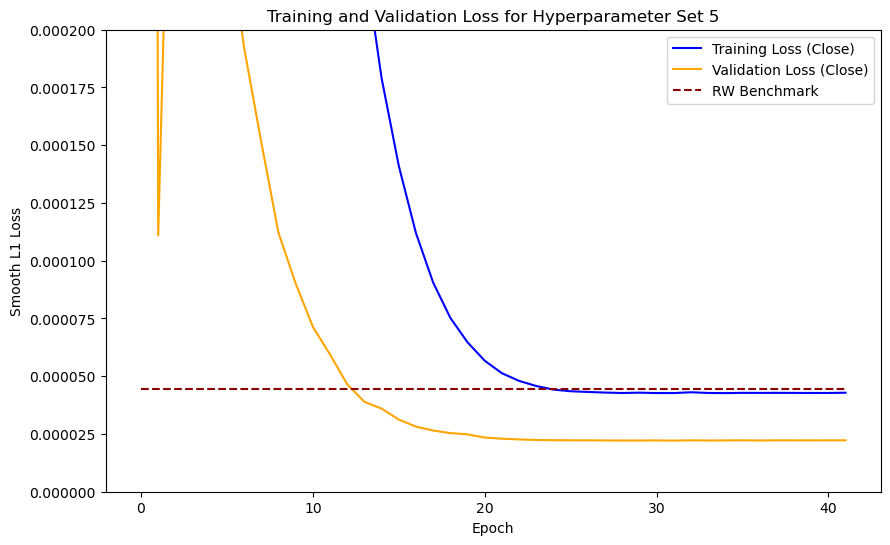

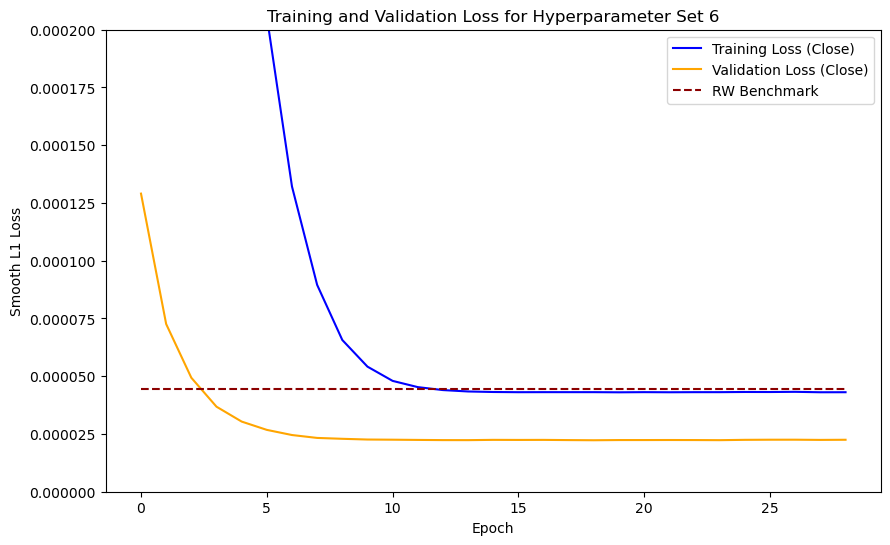

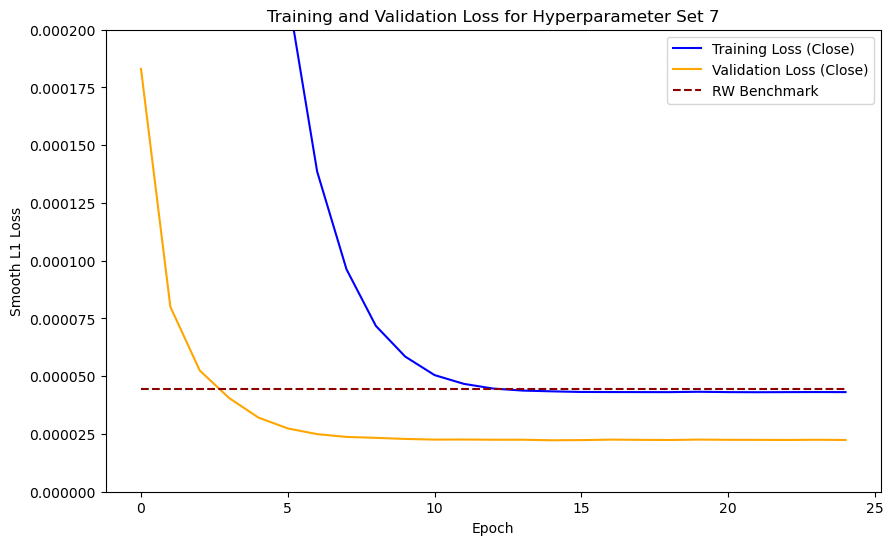

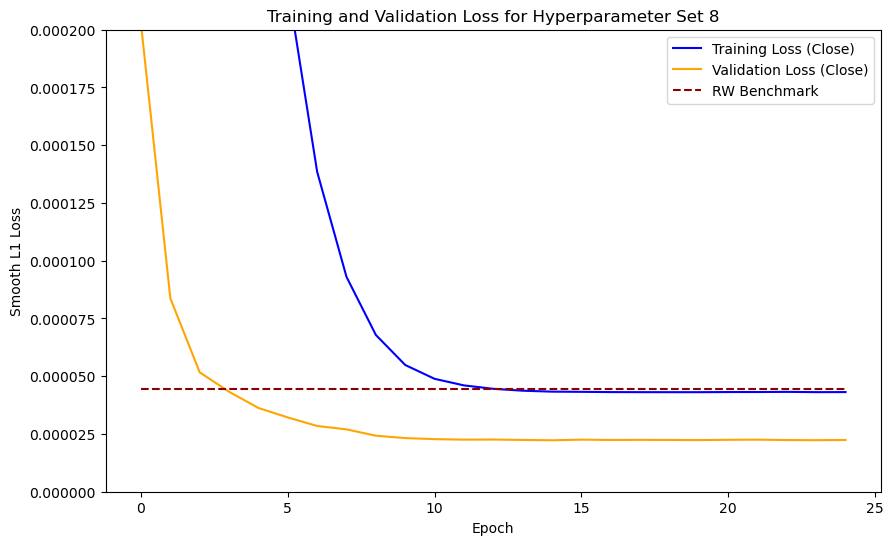

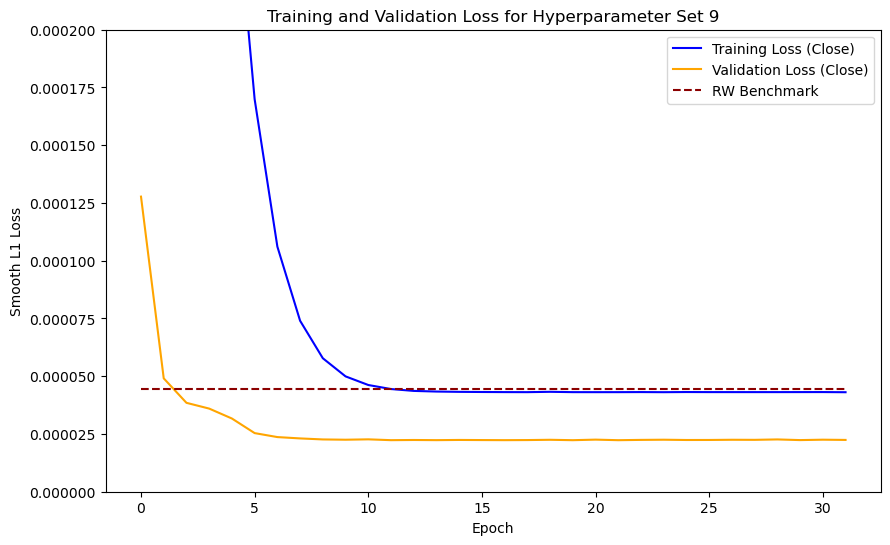

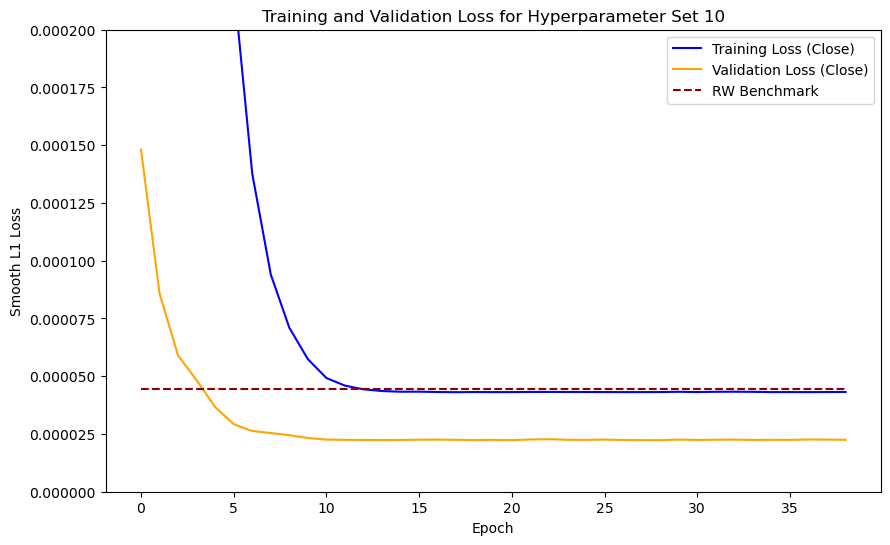

In [24]:
# Plot Performance for Each Hyperparameter Set

#ylim_max = [0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002]
ylim_max = 0.0002

for alt in range(len(hyperparameter_results)):
    train_losses_close = train_losses_close_master[alt]
    val_losses_close = val_losses_close_master[alt]

    # Create RW Benchmark Line for Validation Loss
    RW_benchmark_MSE_valid = model_accuracy_table_RW_valid['MSE'][0]  # Fixed RW Benchmark value
    RW_benchmark_MSE_line = np.full(len(train_losses_close), RW_benchmark_MSE_valid)  # Benchmark line

    # Plot losses and benchmark
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_close, label='Training Loss (Close)', color='blue')
    plt.plot(val_losses_close, label='Validation Loss (Close)', color='orange')
    plt.plot(RW_benchmark_MSE_line, label='RW Benchmark', color='darkred', linestyle='--')
    
    # Formatting
    plt.title(f"Training and Validation Loss for Hyperparameter Set {alt+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Smooth L1 Loss")
    plt.legend()
    plt.ylim([0, ylim_max])  # Adjust based on your loss range
    plt.grid(False)
    plt.show()



Calculating metrics for Hyperparameter Set 1...
Loaded the best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221274, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000

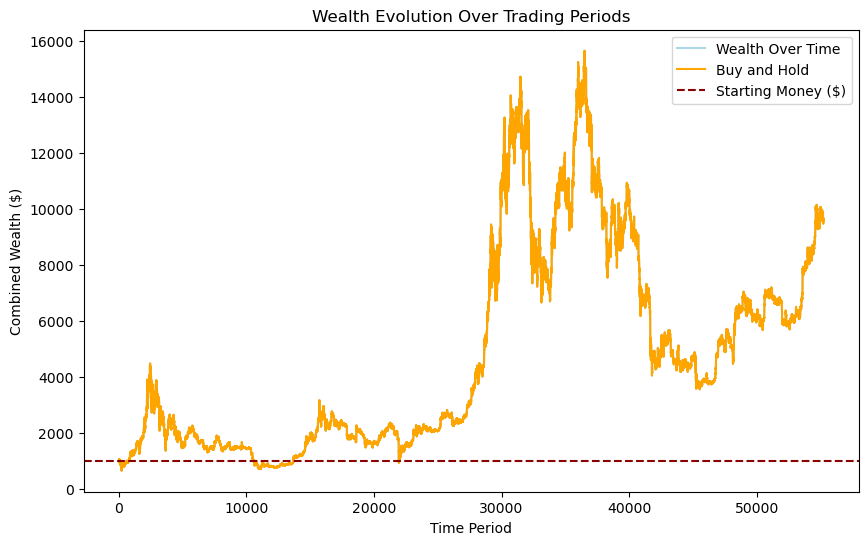


Calculating metrics for Hyperparameter Set 2...
Loaded the best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221449, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000

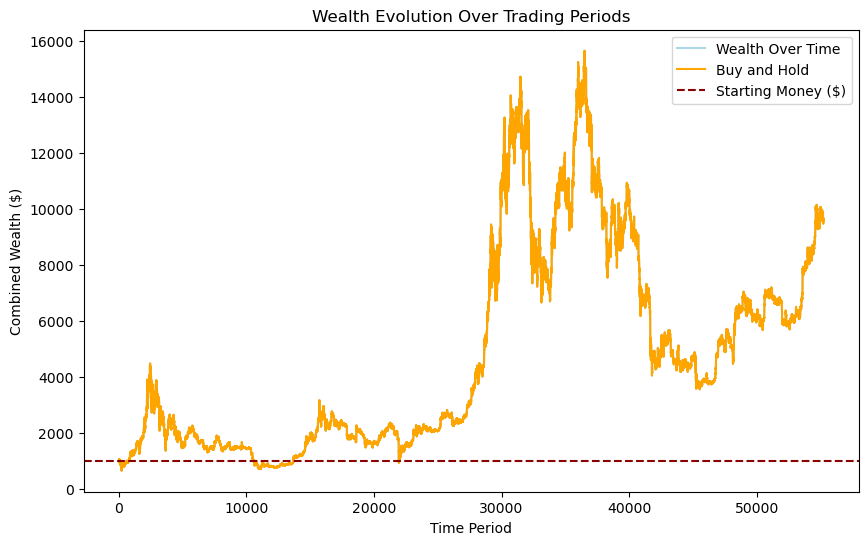


Calculating metrics for Hyperparameter Set 3...
Loaded the best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221290, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000

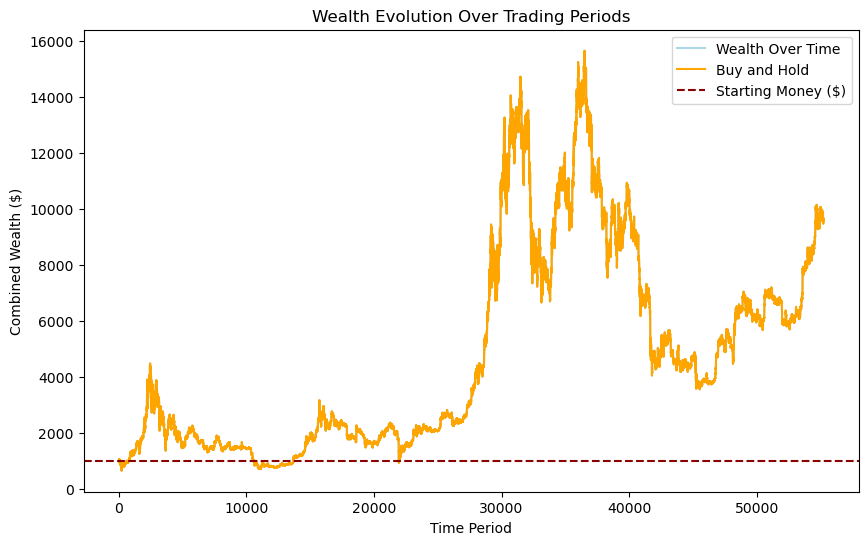


Calculating metrics for Hyperparameter Set 4...
Loaded the best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221127, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000

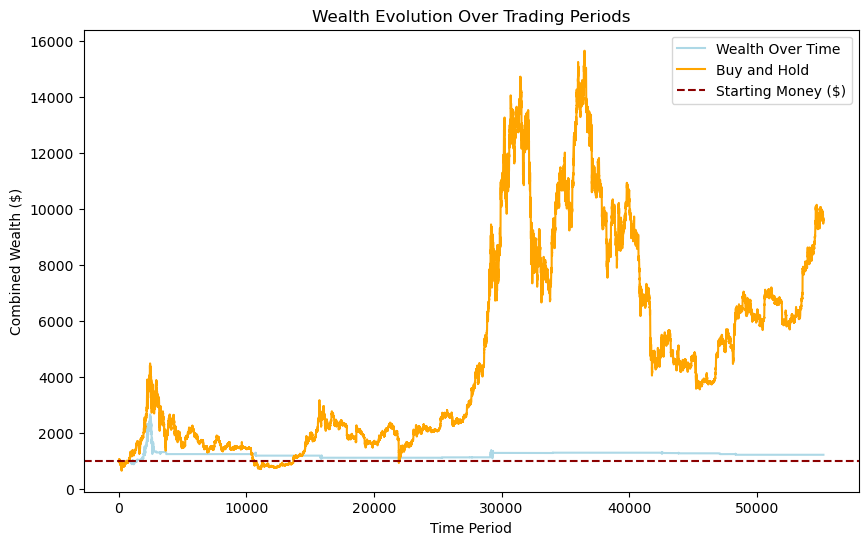


Calculating metrics for Hyperparameter Set 5...
Loaded the best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221384, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000

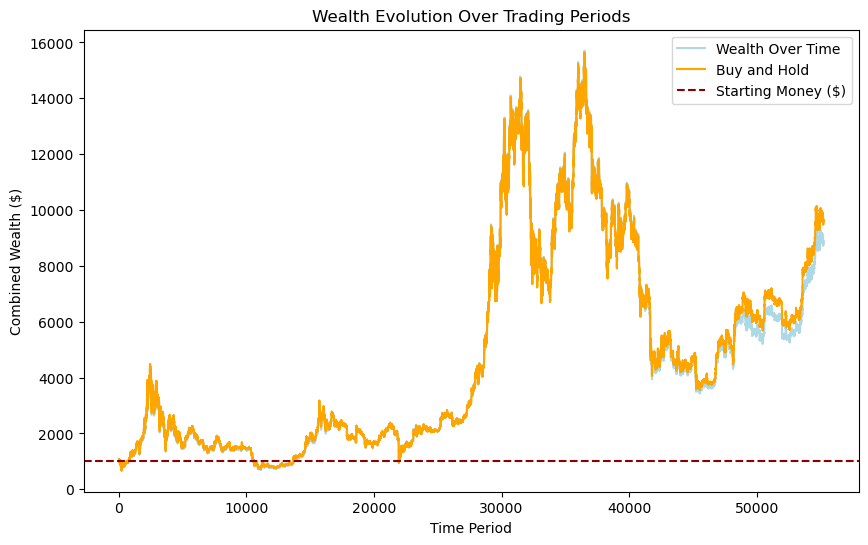


Calculating metrics for Hyperparameter Set 6...
Loaded the best model with Hidden Dim: 64, Num Layers: 1, Batch Size: 64, Validation Loss (Close): 0.0000222822, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000 

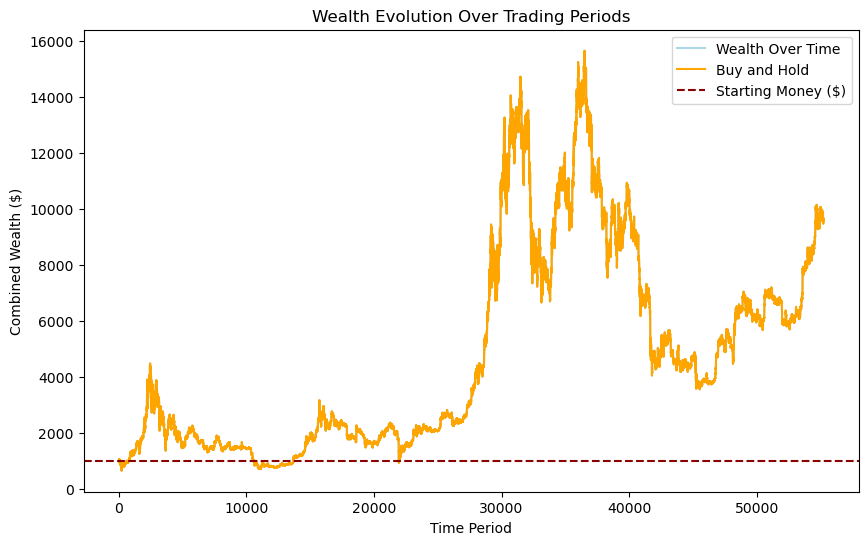


Calculating metrics for Hyperparameter Set 7...
Loaded the best model with Hidden Dim: 64, Num Layers: 1, Batch Size: 64, Validation Loss (Close): 0.0000222724, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000 

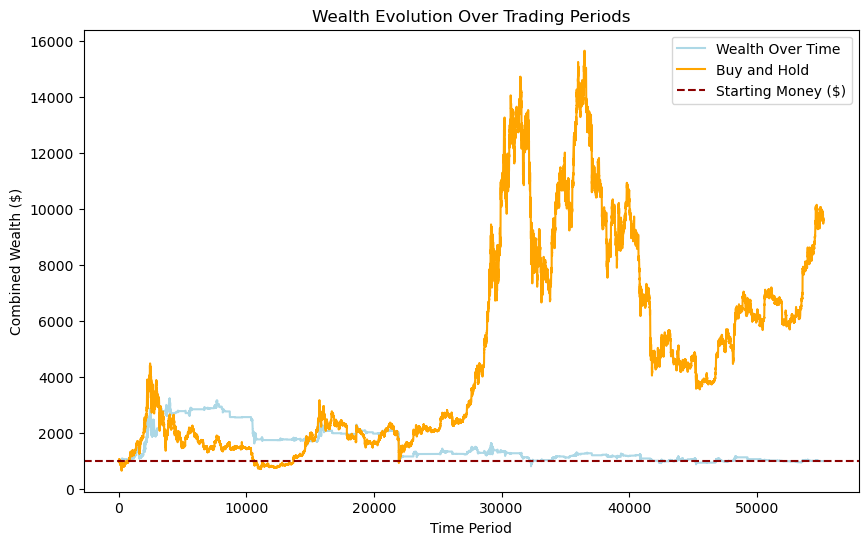


Calculating metrics for Hyperparameter Set 8...
Loaded the best model with Hidden Dim: 64, Num Layers: 1, Batch Size: 64, Validation Loss (Close): 0.0000222687, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000 

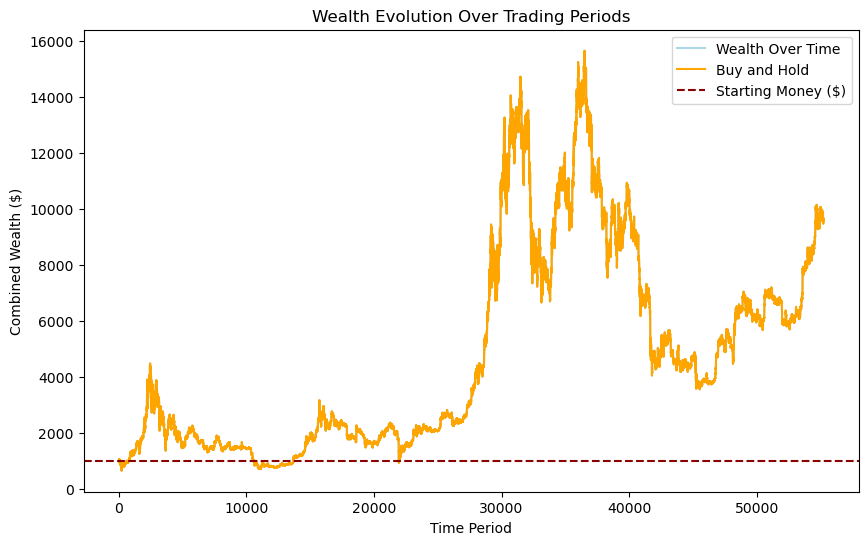


Calculating metrics for Hyperparameter Set 9...
Loaded the best model with Hidden Dim: 64, Num Layers: 1, Batch Size: 64, Validation Loss (Close): 0.0000223083, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000 

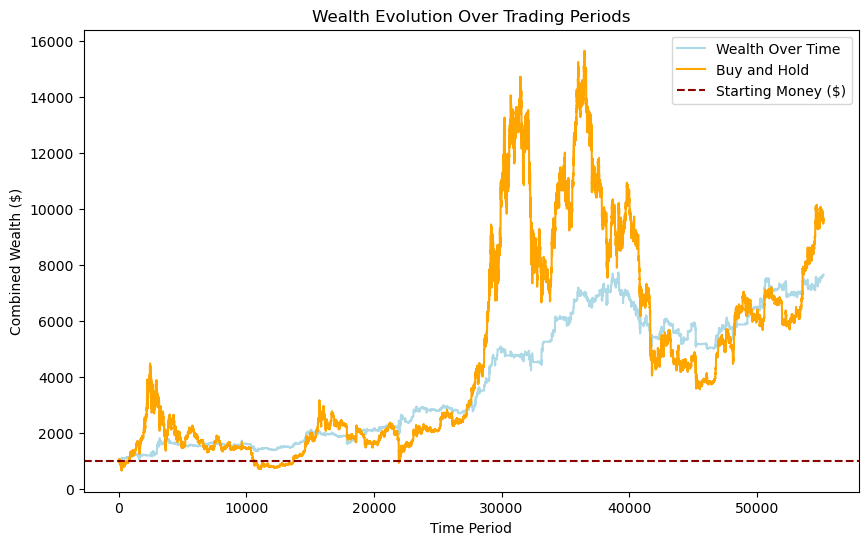


Calculating metrics for Hyperparameter Set 10...
Loaded the best model with Hidden Dim: 64, Num Layers: 1, Batch Size: 64, Validation Loss (Close): 0.0000223236, Gamma: 1
Iteration: 0 / 38665
Iteration: 1000 / 38665
Iteration: 2000 / 38665
Iteration: 3000 / 38665
Iteration: 4000 / 38665
Iteration: 5000 / 38665
Iteration: 6000 / 38665
Iteration: 7000 / 38665
Iteration: 8000 / 38665
Iteration: 9000 / 38665
Iteration: 10000 / 38665
Iteration: 11000 / 38665
Iteration: 12000 / 38665
Iteration: 13000 / 38665
Iteration: 14000 / 38665
Iteration: 15000 / 38665
Iteration: 16000 / 38665
Iteration: 17000 / 38665
Iteration: 18000 / 38665
Iteration: 19000 / 38665
Iteration: 20000 / 38665
Iteration: 21000 / 38665
Iteration: 22000 / 38665
Iteration: 23000 / 38665
Iteration: 24000 / 38665
Iteration: 25000 / 38665
Iteration: 26000 / 38665
Iteration: 27000 / 38665
Iteration: 28000 / 38665
Iteration: 29000 / 38665
Iteration: 30000 / 38665
Iteration: 31000 / 38665
Iteration: 32000 / 38665
Iteration: 33000

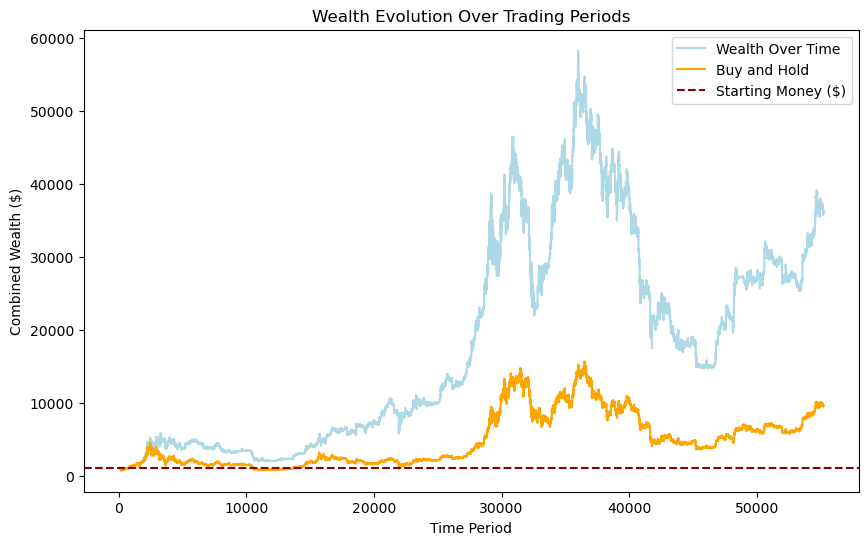

In [25]:
for i, result in enumerate(hyperparameter_results):
    print(f"\nCalculating metrics for Hyperparameter Set {i+1}...")
    
    model = LSTMModel(
        input_dim=input_dim,
        hidden_dim=result["hidden_dim"],
        output_dim=output_dim,
        num_layers=result["num_layers"],
        dropout_rate=result["dropout_rate"]
    ).to(device)

    model.load_state_dict(result["best_model_state"])

    print(f"Loaded the best model with Hidden Dim: {result['hidden_dim']}, "
          f"Num Layers: {result['num_layers']}, "
          f"Batch Size: {result['batch_size']}, "
          f"Validation Loss (Close): {result['best_val_loss_close']:.10f}, "
          f"Gamma: {result['gamma']}")

    batch_size_predictions = 50

    # Function to make predictions in batches
    def predict_in_batches(model, data, batch_size):
        model.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(data), batch_size):
                batch_data = data[i:i + batch_size].to(device)
                batch_predictions = model(batch_data).cpu().numpy()
                predictions.append(batch_predictions)
                if i % 1000 == 0:
                    print(f"Iteration: {i} / {len(data)}")
        return np.concatenate(predictions, axis=0)

    # Make predictions in batches
    train_predictions = predict_in_batches(model, X_train, batch_size_predictions)
    valid_predictions = predict_in_batches(model, X_valid, batch_size_predictions)
    test_predictions = predict_in_batches(model, X_test, batch_size_predictions)

    # Focus only on 'close' price (index 3)
    train_predictions_close_percent = train_predictions[:, :, 3]
    valid_predictions_close_percent = valid_predictions[:, :, 3]
    test_predictions_close_percent = test_predictions[:, :, 3]
    
    train_predictions_close_prices = np.full((train_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    valid_predictions_close_prices = np.full((valid_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    test_predictions_close_prices = np.full((test_predictions_close_percent.shape[0],forecast_horizon),np.nan)
    
    
    train_error_matrix_prices = train_predictions_close_prices.copy
    valid_error_matrix_prices = valid_predictions_close_prices.copy
    test_error_matrix_prices = test_predictions_close_prices.copy
    
    
    train_actuals_close_prices = y_train_prices[:,:,3]
    valid_actuals_close_prices = y_valid_prices[:,:,3]
    test_actuals_close_prices = y_test_prices[:,:,3]
    
    n_cols = X_train_prices.shape[1]
    
    for h in range(forecast_horizon):
        if h == 0:
            train_predictions_close_prices[:,h] = X_train_prices[:,(n_cols-1),3] * (1 + train_predictions_close_percent[:,h])
            valid_predictions_close_prices[:,h] = X_valid_prices[:,(n_cols-1),3] * (1 + valid_predictions_close_percent[:,h])
            test_predictions_close_prices[:,h] = X_test_prices[:,(n_cols-1),3] * (1 + test_predictions_close_percent[:,h])
        else:
            train_predictions_close_prices[:,h] = train_predictions_close_prices[:,h-1] * (1 + train_predictions_close_percent[:,h]) 
            valid_predictions_close_prices[:,h] = valid_predictions_close_prices[:,h-1] * (1 + valid_predictions_close_percent[:,h])
            test_predictions_close_prices[:,h] = test_predictions_close_prices[:,h-1] * (1 + test_predictions_close_percent[:,h])
    
    
    
    # Calculate accuracy metrics
    accuracy_matrix_train = np.zeros((forecast_horizon,6))
    accuracy_matrix_valid = np.zeros((forecast_horizon,6))
    accuracy_matrix_test = np.zeros((forecast_horizon,6))
    
    
    train_horizon_errors = train_predictions_close_prices[:,:] - train_actuals_close_prices[:,:]
    valid_horizon_errors = valid_predictions_close_prices[:,:] - valid_actuals_close_prices[:,:]
    test_horizon_errors = test_predictions_close_prices[:,:] - test_actuals_close_prices[:,:]
    
    for h in range(forecast_horizon):
    
        # Compute accuracy metrics for the unnormalized errors
        accuracy_matrix_train[h,0] = np.sqrt(np.mean(train_horizon_errors[:,h]**2))  # RMSE
        accuracy_matrix_train[h,1] = np.mean(train_horizon_errors[:,h]**2)  # MSE
        accuracy_matrix_train[h,2] = np.mean(train_horizon_errors[:,h])  # ME
        accuracy_matrix_train[h,3] = np.mean(np.abs(train_horizon_errors[:,h] / train_actuals_close_prices[:,h]))  # MAPE
        accuracy_matrix_train[h,4] = np.mean(train_horizon_errors[:,h] / train_actuals_close_prices[:,h])  # MPE
        ss_res_train = np.sum(train_horizon_errors[:, h] ** 2)  # Residual sum of squares
        ss_tot_train = np.sum((train_actuals_close_prices[:, h] - np.mean(train_actuals_close_prices[:, h])) ** 2)  # Total sum of squares
        r_squared_train = 1 - (ss_res_train / ss_tot_train) if ss_tot_train != 0 else 0
        accuracy_matrix_train[h, 5] = r_squared_train  # R^2
        
        # Compute accuracy metrics for the unnormalized errors
        accuracy_matrix_valid[h,0] = np.sqrt(np.mean(valid_horizon_errors[:,h]**2))  # RMSE
        accuracy_matrix_valid[h,1] = np.mean(valid_horizon_errors[:,h]**2)  # MSE
        accuracy_matrix_valid[h,2] = np.mean(valid_horizon_errors[:,h])  # ME
        accuracy_matrix_valid[h,3] = np.mean(np.abs(valid_horizon_errors[:,h] / valid_actuals_close_prices[:,h]))  # MAPE
        accuracy_matrix_valid[h,4] = np.mean(valid_horizon_errors[:,h] / valid_actuals_close_prices[:,h])  # MPE
        ss_res_valid = np.sum(valid_horizon_errors[:, h] ** 2)
        ss_tot_valid = np.sum((valid_actuals_close_prices[:, h] - np.mean(valid_actuals_close_prices[:, h])) ** 2)
        r_squared_valid = 1 - (ss_res_valid / ss_tot_valid) if ss_tot_valid != 0 else 0
        accuracy_matrix_valid[h, 5] = r_squared_valid  # R^2
        
        # Compute accuracy metrics for the unnormalized errors
        accuracy_matrix_test[h,0] = np.sqrt(np.mean(test_horizon_errors[:,h]**2))  # RMSE
        accuracy_matrix_test[h,1] = np.mean(test_horizon_errors[:,h]**2)  # MSE
        accuracy_matrix_test[h,2] = np.mean(test_horizon_errors[:,h])  # ME
        accuracy_matrix_test[h,3] = np.mean(np.abs(test_horizon_errors[:,h] / test_actuals_close_prices[:,h]))  # MAPE
        accuracy_matrix_test[h,4] = np.mean(test_horizon_errors[:,h] / test_actuals_close_prices[:,h])  # MPE
        ss_res_test = np.sum(test_horizon_errors[:, h] ** 2)
        ss_tot_test = np.sum((test_actuals_close_prices[:, h] - np.mean(test_actuals_close_prices[:, h])) ** 2)
        r_squared_test = 1 - (ss_res_test / ss_tot_test) if ss_tot_test != 0 else 0
        accuracy_matrix_test[h, 5] = r_squared_test  # R^2
    
    # Create DataFrame for accuracy table
    model_accuracy_table_train = pd.DataFrame(
        accuracy_matrix_train, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
    ) 
    
    model_accuracy_table_valid = pd.DataFrame(
        accuracy_matrix_valid, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
    ) 
    
    model_accuracy_table_test = pd.DataFrame(
        accuracy_matrix_test, columns=["RMSE", "MSE", "ME", "MAPE", "MPE", "R^2"]
    ) 
    
    print(model_accuracy_table_train)
    print(model_accuracy_table_valid)
    print(model_accuracy_table_test)

    test_actual_one_period_change = test_actuals_close_prices[:,0] - X_test_prices[:,(n_cols-1),3]
    test_actual_one_period_direction = np.sign(test_actual_one_period_change)
    
    test_predictions_one_period_change = test_predictions_close_prices[:,0] - X_test_prices[:,(n_cols-1),3]
    test_predictions_one_period_direction = np.sign(test_predictions_one_period_change)
    
    #print(test_actual_one_period_direction)
    #print(test_predictions_one_period_direction)
    
    test_predictions_one_period_direction_match = test_predictions_one_period_direction == test_actual_one_period_direction
    test_predictions_one_period_direction_match_accuracy = (np.sum(test_predictions_one_period_direction_match,axis=0)/test_predictions_one_period_direction_match.shape[0])
    
    print(f"Directional Accuracy: {test_predictions_one_period_direction_match_accuracy:.4f}%")
    
    # Applying Directional Accuracy Across Horizons
    
    directional_accuracy_horizons = np.full((forecast_horizon,1),np.nan)
    
    for h in range(forecast_horizon):
        test_actual_one_period_change_h = test_actuals_close_prices[:,h] - X_test_prices[:,(n_cols-1),3]
        test_actual_one_period_direction_h = np.sign(test_actual_one_period_change_h)
    
        test_predictions_one_period_change_h = test_predictions_close_prices[:,h] - X_test_prices[:,(n_cols-1),3]
        test_predictions_one_period_direction_h = np.sign(test_predictions_one_period_change_h)
    
        test_predictions_one_period_direction_match_h = test_predictions_one_period_direction_h == test_actual_one_period_direction_h
        test_predictions_one_period_direction_match_accuracy_h = (np.sum(test_predictions_one_period_direction_match_h,axis=0)/test_predictions_one_period_direction_match_h.shape[0])
        
        directional_accuracy_horizons[h,0] = test_predictions_one_period_direction_match_accuracy_h
        
    #print(directional_accuracy_horizons)
    
    directional_accuracy_horizons_output = directional_accuracy_horizons.flatten()
    model_accuracy_table_test["Directional Accuracy"] = directional_accuracy_horizons_output
    
    print(model_accuracy_table_test)

    # Simple Trading Rule --- Set Up Combined Data

    starting_index = X_train.shape[1]
    
    
    predictions_combined = np.concatenate([
        train_predictions_close_prices,
        valid_predictions_close_prices,
        test_predictions_close_prices
    ], axis=0)
    
    actuals_combined = np.concatenate([
        X_train_prices[:, :, 3],  # Closing prices
        X_valid_prices[:, :, 3],
        X_test_prices[:, :, 3]
    ], axis=0)
    
    # Confirm the shape of the combined arrays
    print(f"Predictions Combined Shape: {predictions_combined.shape}")
    print(f"Actuals Combined Shape: {actuals_combined.shape}")
    
    n_periods = predictions_combined.shape[0]
    
    # Simple Trading Rule --- Run Trading Rule
    
    rule_horizon = 0 # 1-step ahead
    
    starting_money = 1000
    coin_holdings = 0
    cash_history = []
    total_wealth_history = []
    buy_and_hold = []
    
    tol = 0
    
    for t in range(n_periods):
        
        price_t = actuals_combined[t, (actuals_combined.shape[1]-1)]
        prediction_t_plus_h = predictions_combined[t,rule_horizon]
            
        if t == 0:
            cash = starting_money
            total_wealth = starting_money
            coin_0 = starting_money / price_t
            
        if coin_holdings == 0 and prediction_t_plus_h > price_t + tol:
            coin_holdings = cash / price_t
            cash = 0
            total_wealth = coin_holdings * price_t
            
        if coin_holdings > 0 and prediction_t_plus_h > price_t + tol:
            total_wealth = coin_holdings * price_t
    
        if coin_holdings > 0 and prediction_t_plus_h < price_t + tol:
            cash = coin_holdings * price_t
            coin_holdings = 0
            total_wealth = cash
    
        if coin_holdings > 0 and prediction_t_plus_h < price_t + tol:
            total_wealth = cash
            
        # if t == (n_periods-1):
        #     cash = coin_holdings * price_t
        #     coin_holdings = 0
        #     total_wealth = cash
            
        cash_history.append(cash)
        # print(t)
        total_wealth_history.append(total_wealth)
        buy_and_hold.append(coin_0 * price_t)
            
        if t % 1000 == 0:
            print(f"Period: {t} / {n_periods}, Cash: {cash:.2f}, Coin Holdings: {coin_holdings:.4f}, Total Wealth: {total_wealth:.2f}, Price_t: {price_t:.2f}, E(Price_t+1): {prediction_t_plus_h:.2f}")
    
    print(f"Final Cash: {cash:.2f}")

    plt.figure(figsize=(10, 6))
    plt.plot(total_wealth_history, label="Wealth Over Time", color="lightblue")
    plt.plot(buy_and_hold, label="Buy and Hold", color="orange")
    plt.axhline(y=starting_money, color="darkred", linestyle="--", label="Starting Money ($)")
    plt.xlabel("Time Period")
    plt.ylabel("Combined Wealth ($)")
    plt.title("Wealth Evolution Over Trading Periods")
    plt.legend()
    plt.grid(False)
    plt.show()

In [26]:
best_result = min(hyperparameter_results, key=lambda x: x["best_val_loss_close"]) #<--- Note this is picking based on closing price accuracy

print(f"Best model with Hidden Dim: {best_result['hidden_dim']}, "
      f"Num Layers: {best_result['num_layers']}, "
      f"Batch Size: {best_result['batch_size']}, "
      f"Validation Loss (Close): {best_result['best_val_loss_close']:.10f}, "
      f"Gamma: {best_result['gamma']}")

for i, result in enumerate(hyperparameter_results):    
    print(f"Best model with Hidden Dim: {result['hidden_dim']}, "
      f"Num Layers: {result['num_layers']}, "
      f"Batch Size: {result['batch_size']}, "
      f"Validation Loss (Close): {result['best_val_loss_close']:.10f}, "
      f"Gamma: {result['gamma']}, "
      f"best_val_loss_close: {result['best_val_loss_close']:.10f}")

Best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221127, Gamma: 1
Best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221274, Gamma: 1, best_val_loss_close: 0.0000221274
Best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221449, Gamma: 1, best_val_loss_close: 0.0000221449
Best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221290, Gamma: 1, best_val_loss_close: 0.0000221290
Best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221127, Gamma: 1, best_val_loss_close: 0.0000221127
Best model with Hidden Dim: 20, Num Layers: 1, Batch Size: 128, Validation Loss (Close): 0.0000221384, Gamma: 1, best_val_loss_close: 0.0000221384
Best model with Hidden Dim: 64, Num Layers: 1, Batch Size: 64, Validation Loss (Close): 0.0000222822, Gamma: 1, best_val_loss_close: 0.0000222822
Best mo